In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 
import logging 
import os
import sys
import copy
import pickle

import lib_operations as operations
import lib_data_load as data_load
#from lib_models_fixed import model_3sr,model_4pr
from lib_models import model_3sr,model_4pr

_plot_vis={}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['style']  = ['solid','dashed','dotted','dashdot']
_plot_vis['marker'] = ['o','v','s','D','X']

make_plot = lambda n,m,s=[1,1]: plt.subplots(n,m,figsize=(m*4*s[0],n*2.6*s[1]),squeeze=False,layout='tight')

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 11})

_T=250

NCAR CSM1.4
Bern3D-LPJ
Bern2.5D-LPJ
CLIMBER2-LPJ
DCESS
GENIE 
LOVECLIM
MESMO
UVic2.9


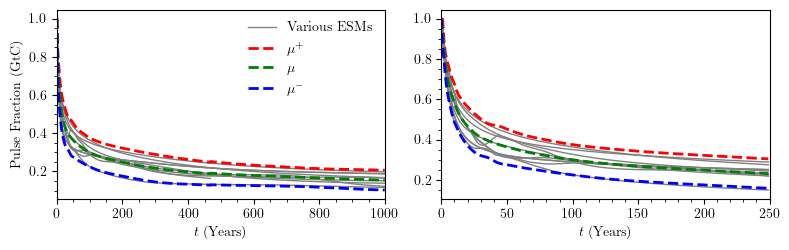

In [36]:
def plot_pulse():

    benchmark_list = ['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']

    T_short = 250
    fig, axs = make_plot(1,2)
    for i,benchmark_i in enumerate(benchmark_list[0:-1]):
        [d,name] = data_load.pulse_fraction(test_type=benchmark_i,T=1000) 

        print(name)

        d = d*1
        t = min(1000,len(d))

        axs[0,0].plot(range(0,len(d)),d,linewidth=1,alpha=1, color='gray')
        axs[0,1].plot(range(0,T_short),d[0:T_short],linewidth=1,alpha=1, color='gray')
    
    axs[0,0].plot(range(0,len(d)),d, label='Various ESMs',linewidth=1,alpha=1, color='gray')
    axs[0,1].plot(range(0,T_short),d[0:T_short], label='Various ESMs',linewidth=1,alpha=1, color='gray')

    #benchmark_list = ['MMMU','MMM','MMMD']#['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']
    benchmark_list = ['MMMU','MMM','MMMD']#['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']
    color_set      = ['red','green','blue']

    [ttttt,_] = data_load.pulse_fraction(test_type='MMM',T=1000) 

    for i,benchmark_i in enumerate(benchmark_list):
        [d,name] = data_load.pulse_fraction(test_type=benchmark_i,T=1000) 

        d= d*1
        t = min(1000,len(d))

        axs[0,0].plot(range(0,len(d)),d,   color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')
        axs[0,1].plot(range(0,T_short),d[0:T_short], color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')
        #axs[0,2].plot(range(250,t),d[250:t], color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')

    axs[0,0].set_ylabel(r'Pulse Fraction (GtC)')
    axs[0,0].set_xlabel(r'$t$ (Years)')
    axs[0,1].set_xlabel(r'$t$ (Years)')
    axs[0,0].minorticks_on()
    axs[0,1].minorticks_on()
    axs[0,0].set_xlim(0,1000)
    axs[0,1].set_xlim(0,T_short)
    axs[0,0].legend(frameon=False,ncol=1)

    fig.savefig('doc/fig/solver_pulse.png', dpi=300)

plot_pulse()

In [3]:
_benchmark_sel ='MMM'

[_data_pulse,_] = data_load.pulse_fraction(test_type=_benchmark_sel,T=_T) 

_data_pulse = _data_pulse

_metric_loss  = []
_metric_pen_1 = []
_metric_pen_2 = []
_metric_pen_3 = []

def constraints(z:np.array,model: callable)->float:

    info       = model()
    p          = info['p']
    a_size     = len(info['a_bounds'])
    m_size     = len(info['m_bounds'])
    a          = z[(0)     :(a_size)]
    m_eq       = z[(a_size):(a_size+m_size)]

    time_scale_max = 10000

    [A,m_eq,x_vec]    = model(a,m_eq)
    [eig_val,eig_vec] = operations.eig(A)
    eig_val_trim      = eig_val[np.abs(eig_val)>1e-12]
    time_scale        = 1.0/np.abs(eig_val_trim)

    c = 0
    # !! Do not accept complex or postive eigen values!
    # !! Condition we do NOT accept
    # These condition can really help zero-order optimizers 
        
    # Real Eigen Values
    # abs sum of imaginary part of eigs should = 0
    c += np.sum( np.abs(eig_val.flatten().imag)) + np.sum(np.abs(eig_vec.flatten().imag))
        
    # Negative Eigen Values
    # abs sum of all postive eigen values should = 0
    c += np.sum(np.abs(eig_val[eig_val>0]))
        
    # Time Scales in range [1/10,time_scale_max] years )
    # sum of timescales less than 1/10 and sum of time scales more than "time_scale_max" should = 0
    c += np.sum(time_scale[time_scale<.1]) + np.sum(time_scale[time_scale>time_scale_max])

    return c

def obj_fun(z:np.array,model:callable,rho:list)->float:
    
    global _data_pulse
    global _metric_loss
    global _metric_pen_1
    global _metric_pen_2
    global _metric_pen_3
    global _T
    
    info       = model()
    p          = info['p']
    a_size     = len(info['a_bounds'])
    m_size     = len(info['m_bounds'])
    a          = z[(0)     :(a_size)]
    m_eq       = z[(a_size):(a_size+m_size)]

    m_eq_base = np.mean(np.array(info['m_bounds']),1)

    [A,m_eq,x_vec] = model(a,m_eq)

    m0    = np.zeros(p)
    m0[0] = _data_pulse[0]

    pen_1 = 0
    pen_2 = 0 
    pen_3 = 0

    loss  = 0

    ############################################################
    # Loss : error metrics for pulse
    ############################################################
    m_sim       = operations.simulate_pulse(A=A,m0=m0,T=_T)
    m_benchmark = _data_pulse
    loss        = operations.l2_err(m_sim[0,:],m_benchmark) / _T  # + 1e-6 * np.linalg.norm(m_eq)
    #loss       += operations.l2_err(m_sim[0,:],m_benchmark)

    ############################################################
    # Pen 1: Eigenvalue
    ############################################################ 
    pen_1 = -np.trace(A)/A.shape[0]#np.linalg.norm(A-A.T,ord='fro')  #-np.trace(A)/A.shape[0]  #np.linalg.norm(A-A.T,ord='fro')

    ############################################################
    # Pen 2: Eigenvalue
    ############################################################ 
    pen_2 = np.linalg.norm( (m_eq_base - m_eq) /m_eq_base)/A.shape[0]
    #pen_2 = np.linalg.norm( (A @ m_eq_base)/m_eq_base)/A.shape[0]
    #pen_2 =   np.dot(A @ m_eq_base,m_eq_base)
        
    ############################################################
    # Pen3: Diff at t=50, m_land = m_ocean 
    ############################################################
    # identify ocean and land reservoirs
    inx_ocean = []
    inx_land  = []
    for m_i_name in info['m_names']:
        if 'O' in m_i_name:
            inx_ocean.append(info['m_names'].index(m_i_name))
        elif 'L' in m_i_name:
            inx_land.append(info['m_names'].index(m_i_name))

    if len(inx_ocean)==0 or len(inx_land)==0:
        diff = 0
    else:
        T    = 20
        m_T  = m_sim[:,T]

        m_to_ocean = np.sum(m_T[inx_ocean])
        m_to_land  = np.sum(m_T[inx_land])

        #eta = 40/25
        eta = 1.0

        diff = np.linalg.norm( m_to_ocean / m_to_land  -  eta )
            
    pen_3 = diff

    _metric_loss.append(loss)
    _metric_pen_1.append(pen_1)
    _metric_pen_2.append(pen_2)
    _metric_pen_3.append(pen_3)
    
    return loss + pen_1*rho[0] + pen_2*rho[1] + pen_3*rho[2]

In [4]:
def fit_model(
    folder_name:str,
    model:callable,
    rho:list,
    seed:int=1,
    verbose:bool=False
    )->list:

    global _data_pulse

    folder_name = str(folder_name)

    try:
        os.makedirs(folder_name)
    except:
        return [False,None]

    logging.root.handlers = []
    
    if verbose:
        logging.basicConfig(
            format='%(asctime)s:%(levelname)s:%(message)s', 
            level=logging.INFO,
            datefmt='%H:%M:%S',
            handlers=[
                logging.FileHandler(folder_name+'/opt.log'),
                logging.StreamHandler(sys.stdout)
                ]
            )
    else:
        logging.basicConfig(
            format='%(asctime)s:%(levelname)s:%(message)s', 
            level=logging.INFO,
            datefmt='%H:%M:%S',
            handlers=[logging.FileHandler(folder_name+'/opt.log')]
            )
        
    logging.info('GENERAL:seed:'+str(seed))
    logging.info('GENERAL:rho:'+str(rho))

    info   = model()
    a_size = len(info['a_bounds'])
    m_size = len(info['m_bounds'])

    # a values change per model and m values are fixed
    bounds_z = info['a_bounds'] + info['m_bounds']
    z0_1       = np.mean(np.array(info['a_bounds']),1)
    z0_2       = np.mean(np.array(info['m_bounds']),1)
    #z0         = np.mea(np.array(bounds_z),1)

    logging.info('GENERAL:bounds_z:'+str(bounds_z))  

    res = scipy.optimize.differential_evolution(
        func        = obj_fun,
        bounds      = bounds_z,
        args        = (model,rho,),
        maxiter     = int(1e6),
        tol         = 1e-6,
        #polish      = False,
        #mutation    = (1.0,1.9),
        popsize     = 100,
        init        ='sobol',
        #seed        = seed,
        x0          = np.concatenate((z0_1,z0_2)),
        constraints = (scipy.optimize.NonlinearConstraint(lambda z:constraints(z,model),0,0))
        )

    for key in res:
        if type(res[key]) is np.ndarray:
            logging.info('OPTIMIZER:'+str(key)+':\n'+str(res[key]))
        else:
            logging.info('OPTIMIZER:'+str(key)+':'+str(res[key]))
            
    # split optimizer into its component
    z    = res.x
    a    = z[(0)     :(a_size)]
    m_eq = z[(a_size):(a_size+m_size)]

    [A,m_eq,x_vec]              = model(a,m_eq)
    [eig_val,eig_vec]           = operations.eig(A)
    [eig_val_left,eig_vec_left] = operations.eig(A.T)

    result          = {}
    result['A']     = A
    result['a']     = a
    result['m_eq']  = m_eq
    result['benchmark_pulse'] = _data_pulse
    result['success'] = res.success,

    logging.info('RESULT:A:\n'+str(A))
    logging.info('RESULT:m_eq:\n'+str(m_eq)+'('+str(np.sum(m_eq))+')')
    logging.info('RESULT:x_vec:\n'+str(x_vec)+'('+str(np.sum(x_vec))+')')
    logging.info('RESULT:time_scale:\n'+str(1/np.abs(eig_val[:-1])))
        
    if folder_name is not None:
        logging.info('SAVE:message:saving bunch of data...')
        with open(folder_name+'/result.pkl', 'wb') as f:
            pickle.dump(result,f)

    return [res.success,result]

In [5]:
def run(rho,model,test_name='result'):
    
    global _metric_loss
    global _metric_pen_1
    global _metric_pen_2
    global _metric_pen_3

    rho  = [float(rho_i) for rho_i in rho ]
    info = model()

    folder_name = test_name+'/'+_benchmark_sel+'-'+ '_'.join(map(str, rho))+'/'+str(info['name'])
    print('\nRunning:',folder_name)
    
    [succ,result] = fit_model(folder_name=folder_name,model=model,rho=rho,)
    
    opt_data                  = {}
    opt_data['_metric_loss']  = _metric_loss
    opt_data['_metric_pen_1'] = _metric_pen_1
    opt_data['_metric_pen_2'] = _metric_pen_2
    opt_data['_metric_pen_3'] = _metric_pen_3
    
    if folder_name is not None:
        logging.info('SAVE:message:saving optimizer data ...')
        with open(folder_name+'/opt_data.pkl', 'wb') as f:
            pickle.dump(opt_data,f)
    
    _metric_loss  = []
    _metric_pen_1 = []
    _metric_pen_2 = []
    _metric_pen_3 = []

    print('\n>>>>>> Done:',folder_name,' succ=',succ)

In [6]:
import multiprocess as mp

rho1_set = np.array([0.0, 0.0001, 0.001, 0.01, 0.1]) #np.array([0]+list(2**np.arange(0,8,2)))*0.001 # ||a_mmm -a_i || : keep variables constnate between models
rho2_set = np.array([0.0, 0.0001, 0.001, 0.01, 0.1]) #np.array([0]+list(2**np.arange(0,8,2)))*0.001 # -tr(A)/p : Reudce average time-scales
rho3_set = np.array([0.0, 0.0001, 0.001, 0.01, 0.1]) #np.array([0]+list(2**np.arange(0,8,2)))*0.001 # -tr(A)/p : Reudce average time-scales

rho_set         = [[rho1,rho2,rho3] for rho3 in rho3_set for rho2 in rho2_set  for rho1 in rho1_set ] 

model_set       = [model_4pr,model_3sr]
task_input_list = [[rho,model_tempate] for rho in rho_set for model_tempate in model_set] 
run_mask        = lambda tak_input: run(test_name='result/4_p/T-'+str(_T),rho=tak_input[0],model=tak_input[1])

with mp.Pool( min( int(mp.cpu_count()/2), int(len(task_input_list)*2))) as pool:
    restult = pool.map(run_mask, task_input_list)


Running:
Running:
Running:
Running:
Running: 
Running:    result/4_p/T-250/MMM-0.0_0.0_0.0/4PR result/4_p/T-250/MMM-0.0_0.0001_0.0/3SRresult/4_p/T-250/MMM-0.001_0.1_0.0/4PRresult/4_p/T-250/MMM-0.0001_0.001_0.0/4PRresult/4_p/T-250/MMM-0.0001_0.01_0.0/3SR
result/4_p/T-250/MMM-0.001_0.0_0.0001/3SR






/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.0001_0.01_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.01_0.0/4PR


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.0_0.0001_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.0001_0.0001_0.0/4PR


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.001_0.0_0.0001/3SR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.0_0.0001/4PR


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +



>>>>>> Done: result/4_p/T-250/MMM-0.001_0.1_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.1_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.001_0.01_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.01_0.0/3SR


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.001_0.1_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.1_0.0/4PR


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.0001_0.001_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.0001_0.001_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.001_0.01_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.01_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.0001_0.001_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.001_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.0_0.0001/4PR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.0_0.0001/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.0_0.0001/3SR  succ= True

Running: result/4_p/T-250/MMM-0.1_0.0_0.0001/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.1_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.1_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.01_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.01_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.1_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.1_0.1_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.01_0.01_0.0/3SR  succ= True

Running:

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



>>>>>> Done: result/4_p/T-250/MMM-0.0_0.0_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.0_0.0_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.001_0.001_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.001_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.0001_0.0001_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.001_0.0001_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.0_0.0_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.0001_0.0_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.1_0.1_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.1_0.1_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.001_0.001_0.0/3SR  succ= True

Running: result/4_p/T-250/MMM-0.01_0.001_0.0/4PR

>>>>>> Done: result/4_p/T-250/MMM-0.1_0.0_0.0001/4PR  succ= True

Running: result/4_p/T-250/MMM-0.1_0.0_0.0001/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.1_0.01_0.0/4PR  succ= True

Running: result/4_p/T-250/MMM-0.1_0.01_0.0/3SR

>>>>>> Done: result/4_p/T-250/MMM-0.1_0.1_0.0/3SR  succ= True

Running: result/4_p